### In the name of God
---
### Deep Learning HW2
### Fine-tuning Resnet



**Name:** Hosna Oyarhoseini

**Std. No.:** 402212503

In [1]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import matplotlib.pyplot as plt
! pip install explainable-cnn

## Data Preparation

In [2]:
# Define the transformations to apply to the images
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
batch_size = 64
num_classes = 10

########################## TODO ##########################
# Download cifar10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
####################### (5 points) #######################

########################## TODO ##########################
# Create data loaders for the train and test datasets
# In this homework we use test dataset as validation dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
####################### (5 points) #######################

Files already downloaded and verified
Files already downloaded and verified


## Model

In [5]:
class Model(nn.Module):
    def __init__(self, num_classes, freeze=False):
        super(Model, self).__init__()

        ########################## TODO ##########################
        # Initialize a ResNet-50 torchvision model with pre-trained weights
        # Modify the last layer of the model (model.fc) and replace it with
        # a sequence of multiple linear layers according to the following structure:
        # model.fc.in_features -> 128 -> 64 -> 32 -> num_classes
        # Use Relu activation functions between linear layers and LogSoftmax at the end

        self.model = models.resnet50(pretrained=True)
        layers = [
            nn.Linear(self.model.fc.in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        ]
        # complete here
        self.model.fc = nn.Sequential(*layers)
        ####################### (20 points) ######################

        ########################## TODO ##########################
        # if freeze falg is true, freeze all model parameters except for the fc layers

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.model.fc.parameters():
                param.requires_grad = True
        ####################### (5 points) #######################

    def forward(self, x):
        return self.model(x)

In [9]:
def train(model, epoch, optimizer, train_loader, criterion=nn.CrossEntropyLoss()):
    # Initialize the running loss and accuracy
    total_loss = 0
    correct = 0
    total_size = 0

    ########################## TODO ##########################
    # Set the model to train mode
    model.train()
    ####################### (5 points) #######################

    # Iterate over the batches of the train loader
    for batch_idx, (data, target) in enumerate(train_loader):
        ########################## TODO ##########################
        # Move the data and target to the device
        data, target = data.cuda(), target.cuda()
        ####################### (5 points) #######################

        # Zero the optimizer gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        # Update the running loss
        total_loss += loss.item()
        total_size += data.size(0)

        ########################## TODO ##########################
        # Update correct variable based on model output and traget
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        ####################### (10 points) ######################

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss / total_size))


    return total_loss / total_size, 100. * correct / len(train_loader.dataset)

def test(model, test_loader, criterion=nn.CrossEntropyLoss()):
    ########################## TODO ##########################
    # Set the model to evaluation mode
    model.eval()
    ####################### (5 points) #######################

    # Initialize the running loss and accuracy
    test_loss = 0
    correct = 0
    # Iterate over the batches of the validation loader
    with torch.no_grad():
        for data, target in test_loader:
            ########################## TODO ##########################
            # Move the data and target to the device
            data, target = data.cuda(), target.cuda()
            ####################### (0 points) #######################
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            # Update the running loss and accuracy
            test_loss += loss.item()

            ########################## TODO ##########################
            # Update correct variable based on model output and traget
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            ####################### (0 points) #######################

    # Calculate the validation loss and accuracy
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, 100. * correct / len(test_loader.dataset)

In [10]:
model_1 = Model(num_classes, freeze=False)
model_2 = Model(num_classes, freeze=True)
model_1

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

## Training

In [11]:
########################## TODO ##########################
# Run the following code for each of the above models
# Based on your resources you can choose number of epochs from 3 to 5
####################### (10 points) #######################
model = model_1
num_epochs = 5
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
model = model.to(device)


####   Train Model
# Initialize variables for early stopping
early_stopping_threshold = 3
epochs_no_improve = 0
early_stop = False
best_val_acc = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, epoch, optimizer, train_loader)
    val_loss, val_acc = test(model, test_loader)

    ########################## TODO ##########################
    # Check early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch > 3 and epochs_no_improve == early_stopping_threshold:
        print('Early stopping!' )
        early_stop = True
        break

    ####################### (10 points) #######################

Train Epoch: 1 [0/50000 (0%)]	Average loss: 0.036434
Train Epoch: 1 [6400/50000 (13%)]	Average loss: 0.036045
Train Epoch: 1 [12800/50000 (26%)]	Average loss: 0.035951
Train Epoch: 1 [19200/50000 (38%)]	Average loss: 0.035828
Train Epoch: 1 [25600/50000 (51%)]	Average loss: 0.035597
Train Epoch: 1 [32000/50000 (64%)]	Average loss: 0.035126
Train Epoch: 1 [38400/50000 (77%)]	Average loss: 0.034313
Train Epoch: 1 [44800/50000 (90%)]	Average loss: 0.033224

Test set: Average loss: 0.0192, Accuracy: 5854/10000 (59%)

Train Epoch: 2 [0/50000 (0%)]	Average loss: 0.022050
Train Epoch: 2 [6400/50000 (13%)]	Average loss: 0.021195
Train Epoch: 2 [12800/50000 (26%)]	Average loss: 0.019735
Train Epoch: 2 [19200/50000 (38%)]	Average loss: 0.018439
Train Epoch: 2 [25600/50000 (51%)]	Average loss: 0.017434
Train Epoch: 2 [32000/50000 (64%)]	Average loss: 0.016522
Train Epoch: 2 [38400/50000 (77%)]	Average loss: 0.015795
Train Epoch: 2 [44800/50000 (90%)]	Average loss: 0.015121

Test set: Average loss

### GradCam

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


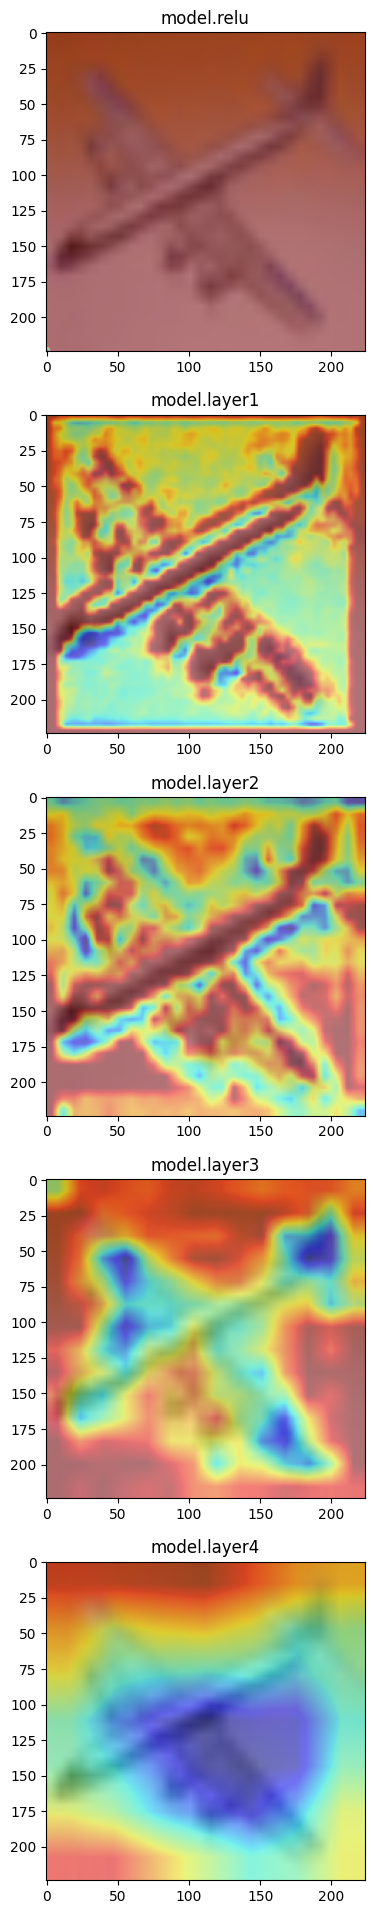

In [13]:
from explainable_cnn import CNNExplainer

classes_name = {
                0: 0, # "airplane"
                1: 1, # "automobile"
                2: 2, # "bird"
                3: 3, # "cat"
                4: 4, # "deer"
                5: 5,  # "dog"
                6: 6, # "frog"
                7: 7, # "horse"
                8: 8, # "ship"
                9: 9 # "truck"
}
layers = ["model.relu", "model.layer1", "model.layer2", "model.layer3", "model.layer4"]
x_cnn = CNNExplainer(model_1, classes_name)

########################## TODO ##########################
# Pick a picture of your choice and Run the following code with your trained model_1

grad_cam = x_cnn.get_grad_cam(
    '/content/airplane4.png', # replace with your image path
    0, # replace with your image label
    (224, 224),
    layers
)
####################### (5 points) #######################

fig, axs = plt.subplots(len(layers), figsize=(10, 24))
# Note that get_grad_cam() returns list of images (numpy array)
for i in range(0, len(layers)):
  axs[i].set_title(layers[i])
  axs[i].imshow(grad_cam[i].astype('uint8'))


#### Explain about one advantage and one limitation of using Grad-CAM (Gradient-weighted Class Activation Mapping) as a method for explaining the predictions of Convolutional Neural Networks (CNNs) (15 point)

Advantage of Grad-CAM:

Localization of Relevance: Grad-CAM provides a fine-grained understanding of where a Convolutional Neural Network (CNN) is focusing to make a particular prediction. Unlike some other interpretability methods that provide a global understanding of the model's decision, Grad-CAM can highlight specific regions in the input image that contribute most to the prediction. This localization of relevance makes Grad-CAM particularly useful for understanding the model's decision-making process and gaining insights into which parts of the input are influential for a given prediction.
Limitation of Grad-CAM:

Lack of Sensitivity to Input Changes: Grad-CAM relies on the gradients of the predicted class score with respect to the feature maps of the last convolutional layer. One limitation is that it may not be very sensitive to subtle changes in the input that might still be relevant for the model's decision. Grad-CAM might highlight large, discriminative regions but may miss smaller details that are crucial for the prediction. This limitation is important to consider when dealing with tasks where small, nuanced features contribute significantly to the model's decision, as Grad-CAM might not capture these subtleties effectively.